In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

**Load and Prepare data**

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

**Train + Validation + Test split**

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp   # ≈ 15% val of total
)

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)

In [6]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

**Model Definition**

In [7]:
class ImprovedIrisNet(nn.Module):
    def __init__(self, input_size=4, hidden1=24, hidden2=16, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, 3)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [9]:
model = ImprovedIrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ImprovedIrisNet(
  (fc1): Linear(in_features=4, out_features=24, bias=True)
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=24, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [10]:
def train_model(max_epochs=300, patience=15):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(max_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        if (epoch + 1) % 30 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_iris_model.pt")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses, val_accs

In [11]:
history = train_model()

Epoch   1 | Train Loss: 0.8095 | Val Loss: 0.6264 | Val Acc: 82.61% | LR: 0.020000
Early stopping at epoch 27


In [12]:
train_losses, val_losses, val_accs = history

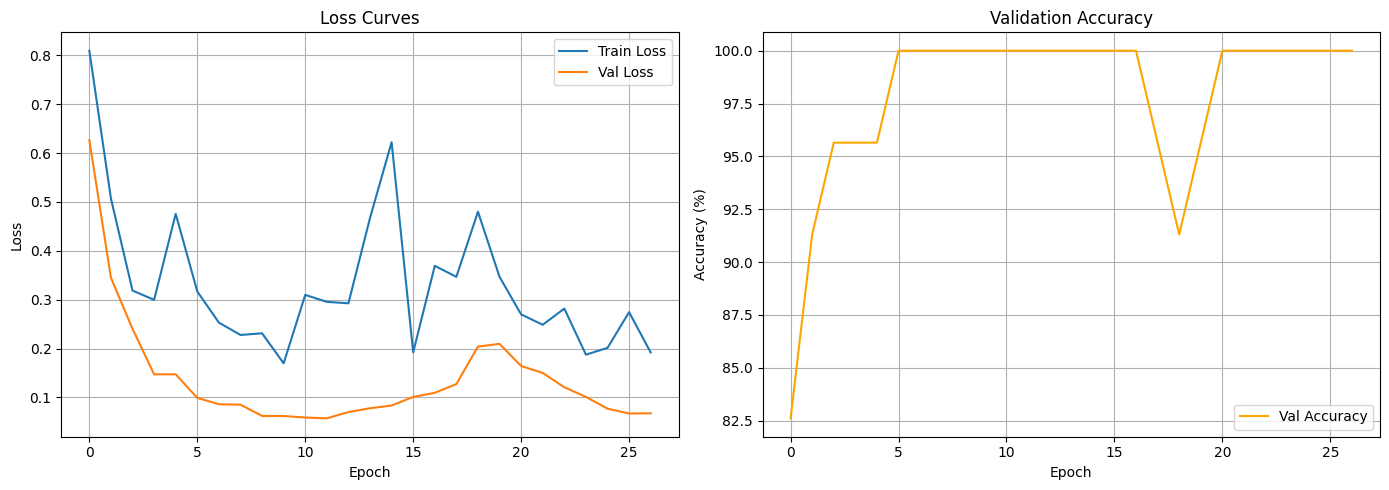

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
model.load_state_dict(torch.load("best_iris_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

In [15]:
acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFinal Test Accuracy: {acc:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Final Test Accuracy: 95.65%

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         7
  versicolor       1.00      0.88      0.93         8
   virginica       0.89      1.00      0.94         8

    accuracy                           0.96        23
   macro avg       0.96      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



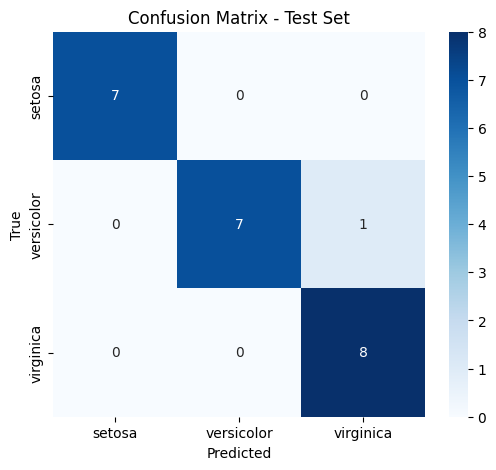

In [16]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [17]:
misclassified = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]
if misclassified:
    print("\nMisclassified test samples:")
    for idx in misclassified[:5]:  # show first few
        true_name  = class_names[all_labels[idx]]
        pred_name  = class_names[all_preds[idx]]
        sample = X_test[idx].numpy() * scaler.scale_ + scaler.mean_  # approx original scale
        print(f"  Sample {idx:2d}: Pred = {pred_name:12}  True = {true_name:12}  Features ≈ {sample.round(1)}")
else:
    print("\nPerfect classification on test set! 🌸")


Misclassified test samples:
  Sample  2: Pred = virginica     True = versicolor    Features ≈ [6.7 3.  5.  1.7]
